### ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecast errors.

In [2]:
#Import Dependancies
from pmdarima.arima import auto_arima
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
plt.style.use(style="seaborn")
%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv("data/BTC_Daily_Final.csv")
df.head(5)

,Unnamed: 0,Date,Close
0,999,2019-02-15,3602.47
1,998,2019-02-16,3618.41
2,997,2019-02-17,3667.58
3,996,2019-02-18,3898.60
4,995,2019-02-19,3907.79


<IPython.core.display.Javascript object>

In [4]:
df = df[["Close"]].copy()
df.describe()


,Close
count,1000.000000
mean,21180.827600
std,18286.852527
min,3602.470000
25%,8423.667500
50%,10535.835000
75%,35646.825000
max,67525.830000


<IPython.core.display.Javascript object>

### An ARIMA model is characterized by 3 terms (p, d, q):

- p is the order of the AR term

- d is the number of differencing required to make the time series stationary

- q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.

### Stationarity

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times. 

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model. 

We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 0.5249676991297756
p-value: 0.985612534989313


<IPython.core.display.Javascript object>

Not stationary as expected so we need to find orders of differencing to make it stationary. We need to check for autocorrelation functioning ACF
#### p

P is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. 



In [6]:
from statsmodels.graphics.tsaplots import plot_acf

<IPython.core.display.Javascript object>

We plot absolute prices over time and plot the autocorrelation

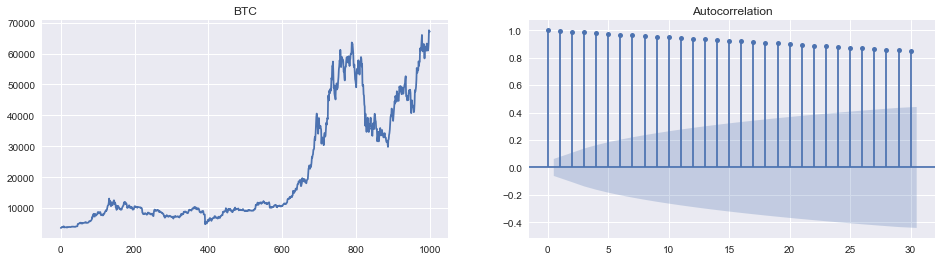

<IPython.core.display.Javascript object>

In [7]:
ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(df.Close)
ax1.set_title("BTC")
plot_acf(df.Close, ax=ax2);
#slight bug in library so we need to add ; to stop doubling up. 

We plot the first order of difference to get the change around a mean of zero and plot the autocorrelations. 

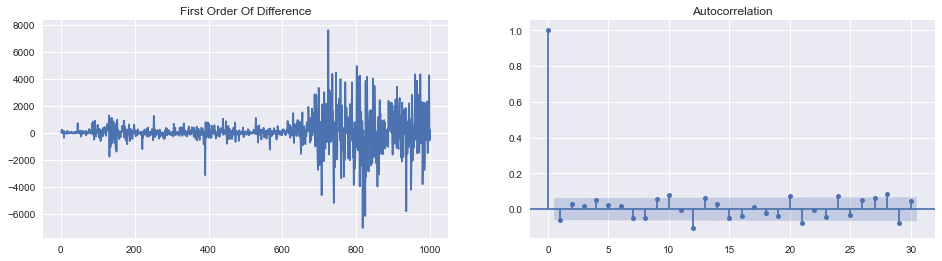

<IPython.core.display.Javascript object>

In [8]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("First Order Of Difference")
plot_acf(diff, ax=ax2);

We plot the second order of difference to check the autocorrelation keeping a mind on over differencing. 

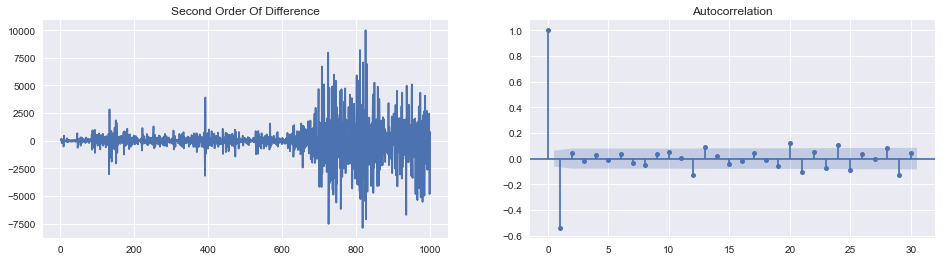

<IPython.core.display.Javascript object>

In [9]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Second Order Of Difference")
plot_acf(diff, ax=ax2);

We notice overdifferencing on the Second order so we choose to stick to the first Order of difference. We can use a tool called ndiffs from arima utilities to confirm our visual inspection.  

In [10]:
from pmdarima.arima.utils import ndiffs

<IPython.core.display.Javascript object>

We check our ACF PLOTS with this tool

In [11]:
ndiffs(df.Close, test="adf")

1

<IPython.core.display.Javascript object>

It confirms our choice of the first order of difference being the best fit. Therefore D=1 


#### Q

Q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms


Import our dependancies. 

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

<IPython.core.display.Javascript object>

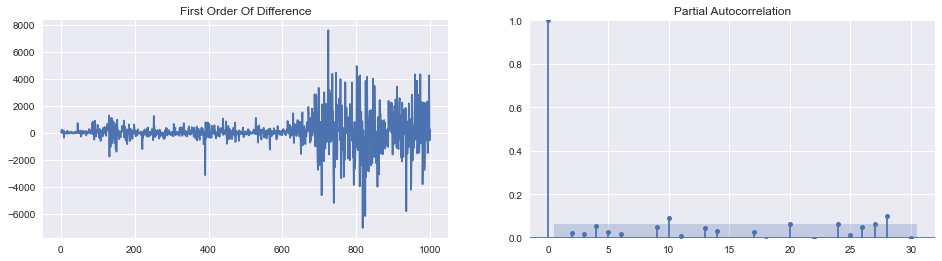

<IPython.core.display.Javascript object>

In [13]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("First Order Of Difference")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

We can see that the first PACF above the significance line is 4. So we choose Q=4 for our ARIMA model. 

- p is the order of the AR term = 10

- d is the number of differencing required to make the time series stationary = 1

- q is the order of the MA term = 4

p = 10 would not run. Kept crashing the model so I ran the next best closest signficant thing being 9. 

In [14]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df.Close, order=(9, 1, 4))
result = model.fit(disp=0)
print(result.summary())

C:\Users\pmellett\Anaconda3\envs\PythonAdv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\pmellett\Anaconda3\envs\PythonAdv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARM

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  999
Model:                 ARIMA(9, 1, 4)   Log Likelihood               -8415.224
Method:                       css-mle   S.D. of innovations           1101.078
Date:                Wed, 17 Nov 2021   AIC                          16860.448
Time:                        13:23:32   BIC                          16934.049
Sample:                             1   HQIC                         16888.422
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            63.8214     36.210      1.763      0.078      -7.149     134.792
ar.L1.D.Close    -1.0474      0.249     -4.209      0.000      -1.535      -0.560
ar.L2.D.Close    -0.8162      0.353     

<IPython.core.display.Javascript object>

## Plot Residuals

(array([2.88035238e-06, 2.16026429e-06, 1.22414976e-05, 4.24851977e-05,
        4.88219729e-04, 1.30335945e-04, 2.73633477e-05, 1.29615857e-05,
        0.00000000e+00, 7.20088096e-07]),
 array([-6686.03674461, -5295.92766423, -3905.81858385, -2515.70950347,
        -1125.60042309,   264.50865729,  1654.61773767,  3044.72681805,
         4434.83589842,  5824.9449788 ,  7215.05405918]),
 <BarContainer object of 10 artists>)

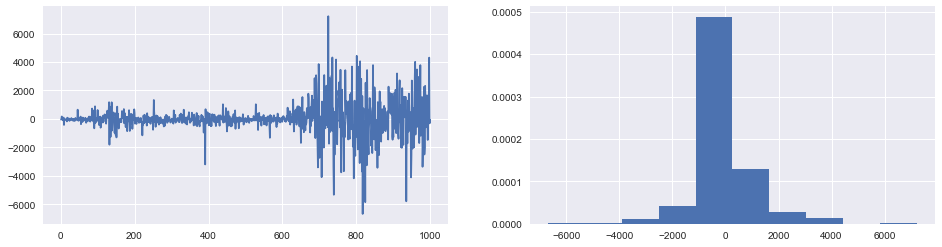

<IPython.core.display.Javascript object>

In [15]:
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

Plot Results of Actual versus Fitted (Training)

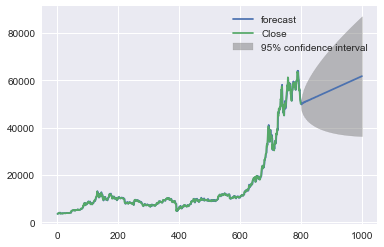

<IPython.core.display.Javascript object>

In [34]:
# Actual vs Fitted
result.plot_predict(
    start=1,
    end=1000,
    dynamic=False,
) ;

## Train Test Split

In [17]:
n = int(len(df) * 0.8)
train = df.Close[:n]
test = df.Close[n:]

<IPython.core.display.Javascript object>

In [18]:
print(len(train))
print(len(test))

800
200


<IPython.core.display.Javascript object>

In [19]:
step = 200

model = ARIMA(train, order=(9, 1, 4))
result = model.fit(disp=0)

# Forecast
fc, se, conf = result.forecast(step)

C:\Users\pmellett\Anaconda3\envs\PythonAdv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\pmellett\Anaconda3\envs\PythonAdv\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, n

<IPython.core.display.Javascript object>

In [20]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  799
Model:                 ARIMA(9, 1, 4)   Log Likelihood               -6491.005
Method:                       css-mle   S.D. of innovations            813.553
Date:                Wed, 17 Nov 2021   AIC                          13012.010
Time:                        13:23:53   BIC                          13082.260
Sample:                             1   HQIC                         13038.998
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            58.0725     32.175      1.805      0.071      -4.990     121.135
ar.L1.D.Close    -0.1229      0.323     -0.380      0.704      -0.756       0.511
ar.L2.D.Close    -0.4213      0.204     -2.070      0.038      -0.820      -0.022
ar.L3.D.Close    -0.4859      0.210     -2.319      0.020      -0.897      -0.075
ar.L4.D.Close     0.3391      0.258      1.313      0.189      -0.167       0.845
ar.L5.D.Close     0.0715      0.048      1.496      0.135      -0.022       0.165
ar.L6.D.Close     0.0729      0.049      1.483      0.138      -0.023       0.169
ar.L7.D.Close    -0.0878      0.058     -1.510      0.131      -0.202       0.026
ar.L8.D.Close     0.0288      0.038      0.751      0.453      -0.046       0.104
ar.L9.D.Close    -0.0720      0.041     -1.762      0.078      -0.152       0.008
ma.L1.D.Close     0.1243      0.323      0.385      0.700      -0.508       0.757
ma.L2.D.Close     0.4834      0.202      2.395      0.017       0.088       0.879
ma.L3.D.Close     0.6085      0.229      2.661      0.008       0.160       1.057
ma.L4.D.Close    -0.3415      0.302     -1.131      0.258      -0.933       0.250
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0659           -0.0000j            1.0659           -0.5000
AR.2            0.2026           -1.0086j            1.0288           -0.2185
AR.3            0.2026           +1.0086j            1.0288            0.2185
AR.4           -1.0667           -0.9996j            1.4618           -0.3802
AR.5           -1.0667           +0.9996j            1.4618            0.3802
AR.6            1.3906           -0.4986j            1.4773           -0.0548
AR.7            1.3906           +0.4986j            1.4773            0.0548
AR.8            0.2065           -1.6117j            1.6249           -0.2297
AR.9            0.2065           +1.6117j            1.6249            0.2297
MA.1           -1.1424           -0.0000j            1.1424           -0.5000
MA.2            0.1805           -0.9836j            1.0000           -0.2211
MA.3            0.1805           +0.9836j            1.0000            0.2211
MA.4            2.5635           -0.0000j            2.5635           -0.0000
-----------------------------------------------------------------------------
"""

<IPython.core.display.Javascript object>

## Forecast the first Array to check 

In [21]:
fc

array([50211.04536604, 49815.05310274, 49750.08175165, 50014.77142811,
       50287.58281791, 50249.46558152, 50298.79045718, 50325.23940916,
       50640.857858  , 50672.79244929, 50657.76149177, 50588.28166298,
       50789.72395895, 50909.21001346, 50962.88502889, 50852.68429573,
       50949.61172026, 51084.83329014, 51223.14661438, 51156.0776636 ,
       51166.9883078 , 51253.09078617, 51434.17720622, 51449.22016259,
       51434.51104908, 51449.27306583, 51612.26262232, 51702.05483118,
       51719.47669318, 51688.57855485, 51791.77791362, 51912.93007617,
       51988.40585826, 51959.85493942, 51999.92651089, 52103.30653676,
       52223.54220274, 52236.50419471, 52243.05774604, 52301.06279505,
       52429.33829889, 52494.12580093, 52507.40806807, 52524.19346689,
       52625.4814342 , 52723.43831537, 52770.64400467, 52773.0816726 ,
       52833.06537279, 52932.2965289 , 53015.70649182, 53033.90301457,
       53062.79775356, 53137.97284773, 53238.9848752 , 53289.05415798,
      

<IPython.core.display.Javascript object>

## Look at the confidence Level

In [22]:
conf

array([[48616.51138262, 51805.57934945],
       [47558.46082053, 52071.64538496],
       [46927.57346339, 52572.59003992],
       [46624.66862107, 53404.87423515],
       [46445.05875898, 54130.10687685],
       [46003.12472938, 54495.80643367],
       [45647.65658565, 54949.92432871],
       [45319.71108594, 55330.76773237],
       [45300.54241009, 55981.17330591],
       [45062.20826518, 56283.37663339],
       [44775.07335529, 56540.44962826],
       [44433.2240679 , 56743.33925806],
       [44363.90944026, 57215.53847764],
       [44250.21810627, 57568.20192066],
       [44080.9180788 , 57844.85197897],
       [43748.71460502, 57956.65398645],
       [43609.85095535, 58289.37248516],
       [43529.410107  , 58640.25647327],
       [43467.24985229, 58979.04337648],
       [43208.71586801, 59103.43945919],
       [43015.01106459, 59318.96555101],
       [42900.9926925 , 59605.18887983],
       [42893.45890722, 59974.89550523],
       [42735.08957703, 60163.35074816],
       [42540.91

<IPython.core.display.Javascript object>

Forecast our Lower and Upper Bounds

In [23]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:, 0], index=test[:step].index)
upper = pd.Series(conf[:, 1], index=test[:step].index)

<IPython.core.display.Javascript object>

## Plot the Forecast Versus the Actual

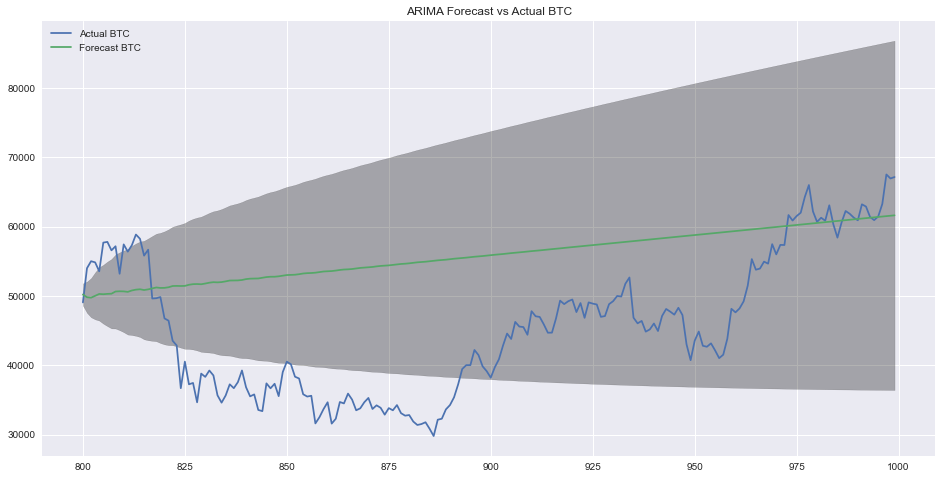

<IPython.core.display.Javascript object>

In [35]:
plt.figure(figsize=(16, 8))
plt.plot(test[:step], label="BTC Close")
plt.plot(fc, label="BTC Prediction")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.3)
plt.title("ARIMA Forecast vs Actual BTC")
plt.legend(loc="upper left")

In [39]:
testdf = pd.DataFrame(test)
testdf.head()

,Close
800,49066.77
801,54001.39
802,55011.97
803,54846.22
804,53555.00


<IPython.core.display.Javascript object>

In [40]:
testfc = pd.DataFrame(fc)
C.head()

,0
800,50211.045366
801,49815.053103
802,49750.081752
803,50014.771428
804,50287.582818


<IPython.core.display.Javascript object>

In [42]:
# Using .rename(columns={}) in order to rename columns
testfc = testfc.rename(columns={0:"Predictions"})
testfc.head()

,Predictions
800,50211.045366
801,49815.053103
802,49750.081752
803,50014.771428
804,50287.582818


<IPython.core.display.Javascript object>

In [46]:
BTC_ARIMA_Results = pd.merge(testdf, testfc on="Index")
BTC_ARIMA_Results.head()

SyntaxError: invalid syntax (<ipython-input-46-bf198de1bb8f>, line 1)

ERROR:root:Cannot parse: 1:44: BTC_ARIMA_Results = pd.merge(testdf, testfc on=["Index"])
Traceback (most recent call last):
  File "C:\Users\pmellett\Anaconda3\envs\PythonAdv\lib\site-packages\lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "C:\Users\pmellett\Anaconda3\envs\PythonAdv\lib\site-packages\lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "C:\Users\pmellett\Anaconda3\envs\PythonAdv\lib\site-packages\black\__init__.py", line 1057, in format_str
    src_node = lib2to3_parse(src_contents.lstrip(), mode.target_versions)
  File "C:\Users\pmellett\Anaconda3\envs\PythonAdv\lib\site-packages\black\parsing.py", line 96, in lib2to3_parse
    raise exc from None
black.parsing.InvalidInput: Cannot parse: 1:44: BTC_ARIMA_Results = pd.merge(testdf, testfc on=["Index"])


In [44]:
dfcombo  = testdf.index.union(testfc.index)
dfcombo
#df = pd.concat([
        #df_small.Price.reindex(uidx).interpolate('index'),
       # df_large['Last trade price'].reindex(uidx).interpolate('index'),
   # ], axis=1, keys=['Small', 'Large'])

RangeIndex(start=800, stop=1000, step=1)

<IPython.core.display.Javascript object>

In [45]:
dfcombo.head()

AttributeError: 'RangeIndex' object has no attribute 'head'

<IPython.core.display.Javascript object>

In [ ]:
BTC_ARIMA_Results = pd.merge(testdf, testfc on=["Index"])

We can run some code to try and loop throught and find the optimal p q d

In [ ]:
model = auto_arima(
    df.Close,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=9,
    max_q=9,
    m=1,  # frequency of series
    d=None,  # determine 'd'
    seasonal=False,  # no seasonality
    trace=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16886.371, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16886.055, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16884.609, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16884.794, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16887.213, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16886.098, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16887.995, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16886.158, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.667 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>